# 사람이 말하는 단어를 인공지능 모델로 구분해보자

# 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

## 평가문항	상세기준
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다. : 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다. : 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다. : evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os

data_path = '/content/drive/Shared drives/GOFOODA/DOS/wav/speech_wav_8000.npz'
speech_data = np.load(data_path)

# (1) 1차원 Wave 데이터 셋 - (50620, 8000)

## - npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어 있음
## - 1초 길이의 오디오 음성 데이터 50620개, 각각 8000개의 샘플 데이터를 가짐
## - Wave data shape: (50620, 8000)

In [ ]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


- 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이뤄져 있습니다.
- 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용하겠습니다.
- 모두 1초의 길이를 가지는 오디오 음성데이터이여서 각각 8000개의 sample data를 가지고 있습니다.
- 데이터셋은 캐글의 음성 인식 챌린지의 데이터입니다. Kaggle/TensorFlow Speech Recognition Challenge. This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.
- 위에서 설명한 데이터가 맞는지 확인해봅시다.

In [ ]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  13073
Wave data shape :  (8000,)
label :  ['right']


# Train/Test 데이터셋 구성하기
## Label data 처리
- 현재 단어의 정답은 Text 형태로 이뤄져있습니다. 학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.

- 아래는 구분해야할 label 목록입니다.

- ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]

- 이외 데이터들은 'unknown', 'silence'로 분류되어 있습니다.

In [ ]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

- Text 이루어진 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하겠습니다.
- int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있습니다.

In [ ]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

# 학습을 위한 데이터 분리
- sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리하겠습니다.
- test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있습니다.

In [ ]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])

[[ 3.2983383e-03  4.7124051e-03  5.4543605e-05 ...  2.6580240e-03
   2.1573512e-03 -1.7908403e-03]
 [ 5.6795338e-03  8.0607785e-03  2.4221700e-03 ...  2.0695287e-03
   1.1521906e-03 -2.5772569e-03]
 [ 1.0057737e-02  1.5901750e-02  1.1686280e-02 ...  2.2856840e-03
   4.7453046e-03  5.0665708e-03]
 ...
 [ 5.1951893e-03  8.1976531e-03  2.1406098e-03 ...  4.9997200e-03
   8.3122933e-03  3.3171824e-03]
 [-1.9664802e-03 -3.3301760e-03 -2.3465890e-03 ...  3.2195398e-03
   2.1567089e-03  3.0912540e-03]
 [ 9.7465701e-05  6.1828183e-04 -7.0188160e-04 ...  6.6830561e-04
   3.3224150e-04  4.0039609e-04]]


나눠진 데이터셋을 확인해 보겠습니다.

In [ ]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


# Hyper-parameters setting
- 학습을 위한 하이퍼파라미터를 설정해줍니다.모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.
- 후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.



In [ ]:
batch_size = 128
max_epochs = 100

# the save point
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/wav/YesicaKim/'

checkpoint_dir

'/content/drive/Shared drives/GOFOODA/DOS/wav/YesicaKim/'

# Data setting
- tf.data.Dataset을 이용해서 데이터셋을 구성해주겠습니다.
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

- map 함수는 dataset이 데이터를 불러올때마다 동작해주는 일종의 데이터 전처리 함수입니다.
- 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.
- map 함수는 중첩해서 사용이 가능합니다.

In [ ]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

## tf.data.Dataset 함수를 구성하겠습니다.
- batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수입니다.


In [ ]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


# (1-1) Wave Classification 첫번째 모델 구현 - (50620, 8000)

## - Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
## - Conv1D layer를 이용: Conv, batch norm, dropout, dense layer 등을 이용해 모델 구성

In [ ]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)         

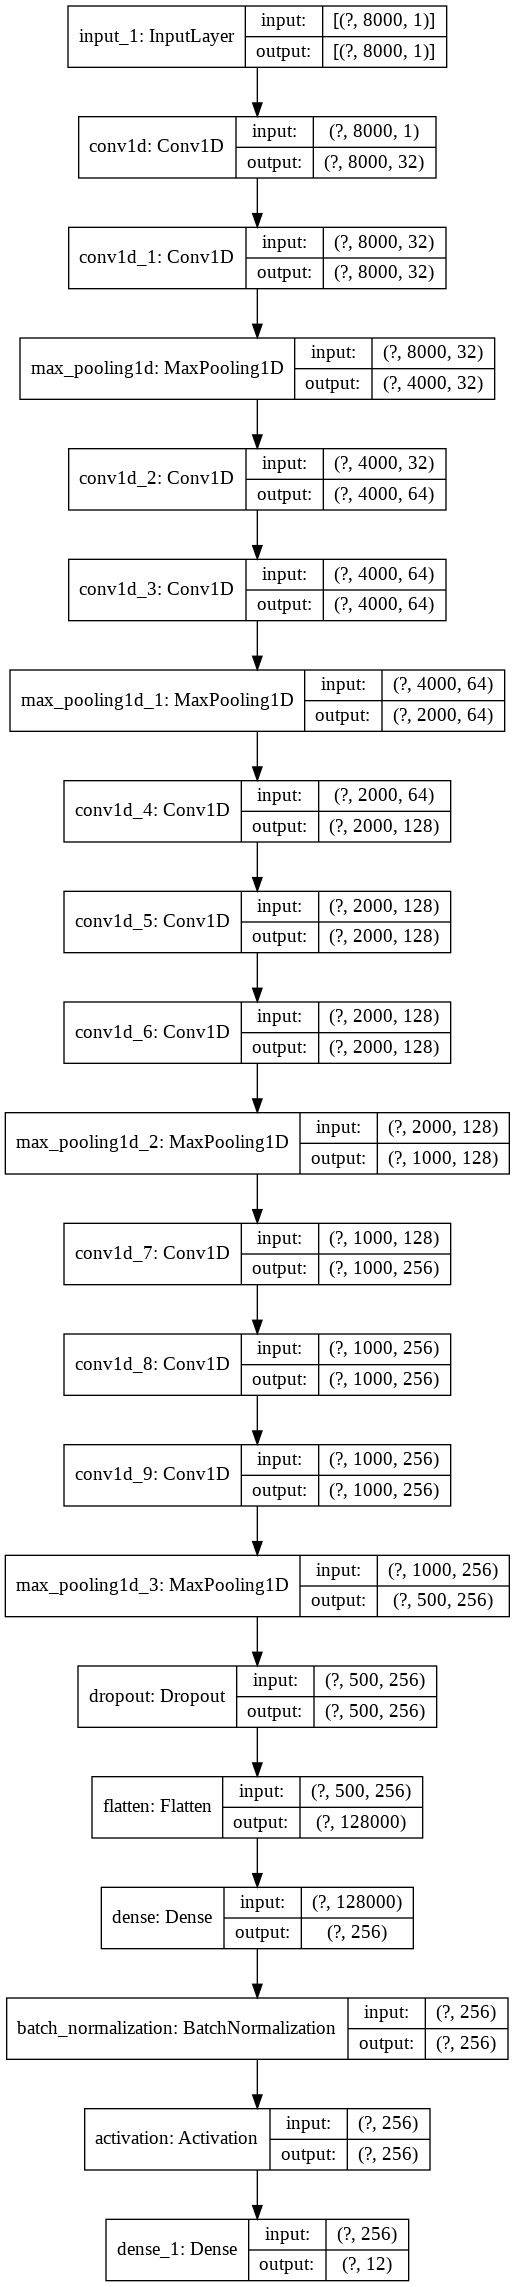

In [ ]:
tf.keras.utils.plot_model(model_wav, '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav.png', show_shapes=True)

# Loss
- 현재 라벨이 될 수 있는 12개의 단어 class를 가지고 있습니다.
- 해당 class를 구분하기 위해서는 multi-class classification이 필요하며, 이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용하겠습니다.



In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

# Training
## Callback
- model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다.
- 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.
- Model Checkpoint callback은 모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
- 현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.

In [ ]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_ckp.h5'

# 새 섹션

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='auto', verbose=1)

In [ ]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback, es]
                    )

model_wav.save('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_Model.h5')

Epoch 1/100
355/355 [==============================] - ETA: 0s - loss: 1.4079 - accuracy: 0.5370
Epoch 00001: val_accuracy improved from -inf to 0.57252, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_ckp.h5
355/355 [==============================] - 54s 153ms/step - loss: 1.4079 - accuracy: 0.5370 - val_loss: 1.3578 - val_accuracy: 0.5725
Epoch 2/100
355/355 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7506
Epoch 00002: val_accuracy improved from 0.57252 to 0.75681, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_ckp.h5
355/355 [==============================] - 54s 152ms/step - loss: 0.8251 - accuracy: 0.7506 - val_loss: 0.7678 - val_accuracy: 0.7568
Epoch 3/100
355/355 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.8075
Epoch 00003: val_accuracy improved from 0.75681 to 0.78686, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_ckp.h5
355/355 [=====================

# 학습 결과 Plot
- model.fit 함수는 학습 동안의 결과를 return해줍니다.
- return 값을 기반으로 loss와 accuracy를 그래프로 표현하겠습니다.
- fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있습니다.
- train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있습니다.

- 출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인해볼 수 있습니다.

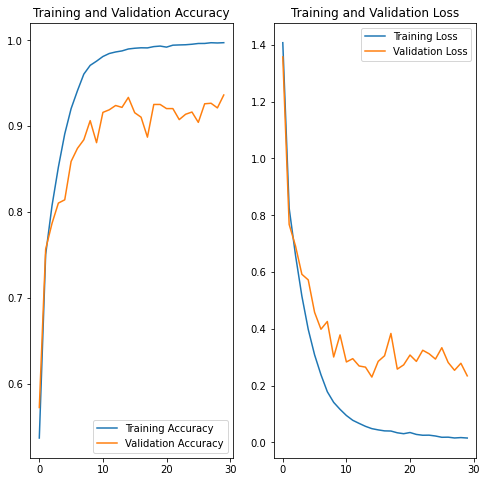

In [ ]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation
- Test dataset을 이용해서 모델의 성능을 평가합니다.

- 실습삼아 checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비를 해보겠습니다.

In [ ]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_ckp.h5'
model_wav.load_weights(checkpoint_dir)

- Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하겠습니다.

In [ ]:
results = model_wav.evaluate(test_dataset)

40/40 [==============================] - 2s 41ms/step - loss: 0.2347 - accuracy: 0.9364


In [ ]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.235
accuracy value: 93.6389%


# Model Test
- Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해보아요.



In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  no


In [ ]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: no


# Skip-Connection model을 추가해보자
## Skip-Connection model 구현
- 이전 스텝에서 우리는 Conv1D 기반의 간단한 분류 모델을 구현해서 학습 및 테스트를 진행해 보았습니다. 간단한 모델임에도 정확도가 나쁘지 않았을 것입니다.

- 하지만 여러분들은 이미지처리 모델을 다루면서 ResNet 등 skip-connection을 활용한 모델들이 훨씬 안정적으로 높은 성능을 낼 수 있음을 배워왔을 것입니다. 그렇다면 이번 음성처리 모델에 적용해도 비슷한 개선 효과를 낼 수 있지 않을까요?

- 기존의 모델을 skip-connection이 추가된 모델로 변경해 학습을 진행해보겠습니다.

![titla](skip-connection.max-800x600.png)

- 그림에서 보듯이 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨을 확인할 수 있습니다.
- Concat을 이용한 방식으로 구현하면 됩니다.

- tf.concat([#layer output tensor, layer output tensor#], axis=#)

- 우리가 사용하는 데이터가 1차원 audio 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성해보겠습니다.

# (1-2) Wave Classification 두번째 모델 구현 - (50620, 8000)

## - Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
## - 위의 Conv1D layer를 이용하지만 Skip Connection을 추가해서 모델을 구성함

In [ ]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

y_pred: no
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________

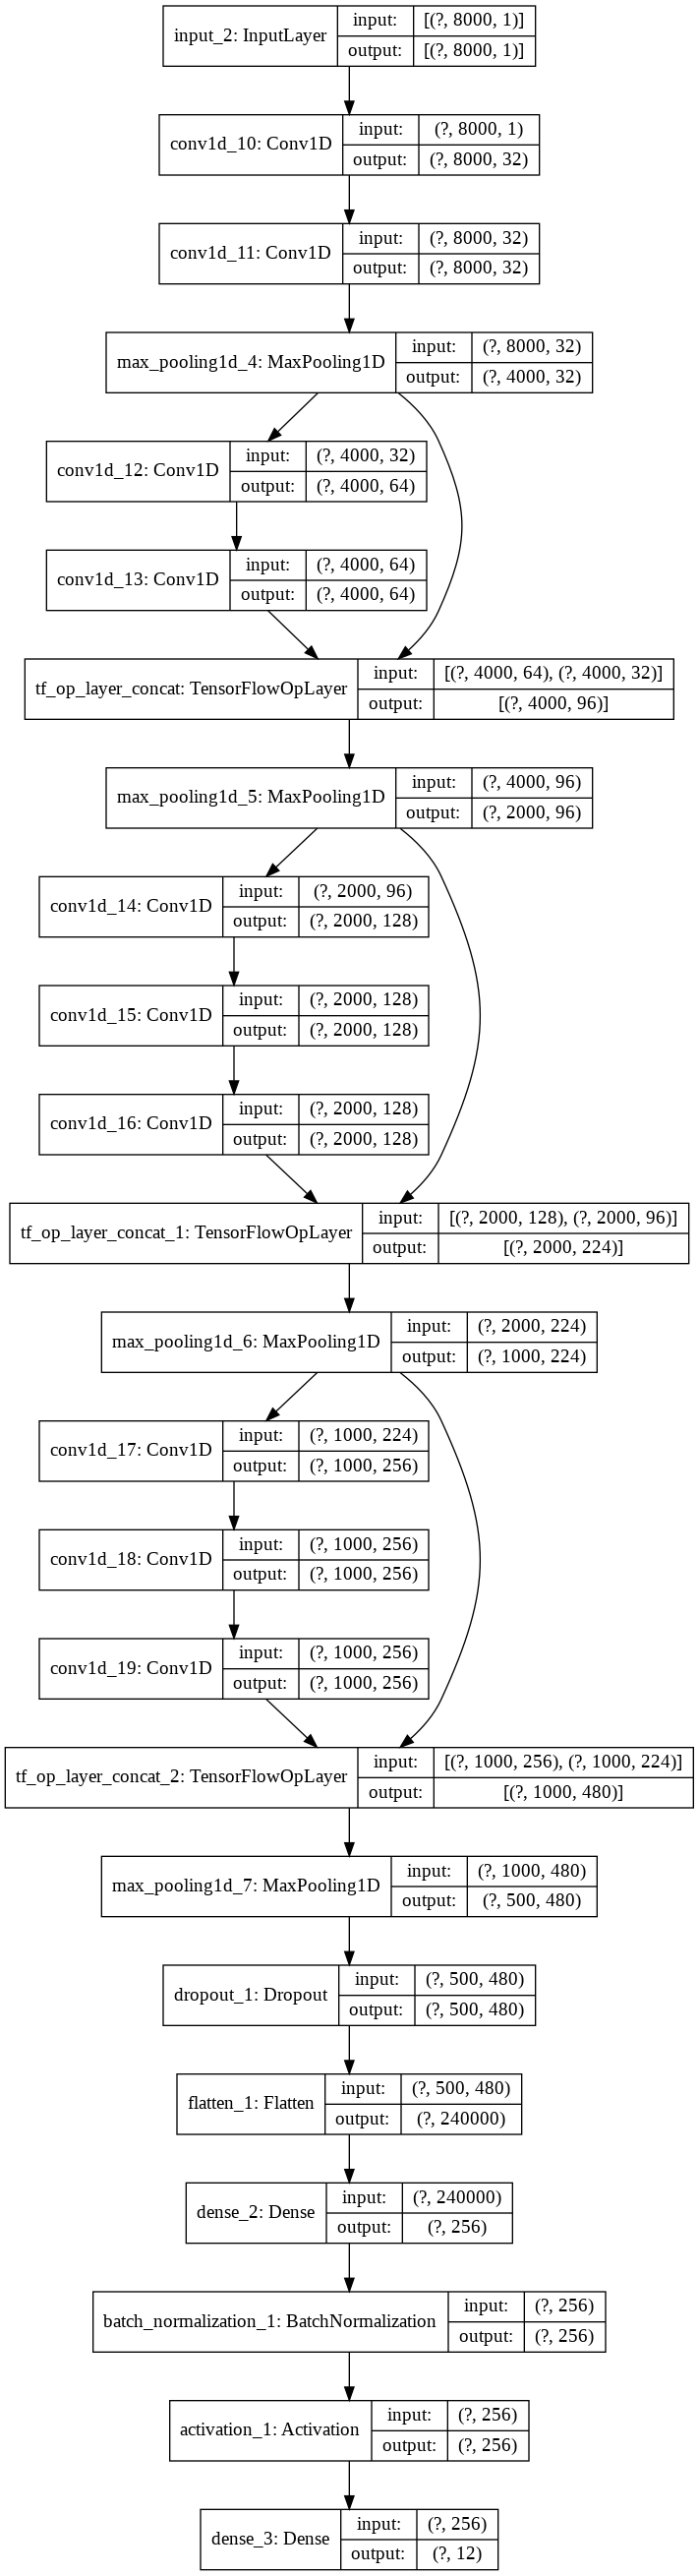

In [ ]:
tf.keras.utils.plot_model(model_wav_skip, '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_Skip.png', show_shapes=True)

- 모델 구성만 달라졌을 뿐, 그 외 Task구성이나 데이터셋 구성, 훈련 과정은 동일합니다.

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [ ]:
# the save point
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_Skip_ckp.h5'


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='auto', verbose=1)

In [ ]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback, es]
                    )
model_wav_skip.save('./Wav_Skip_Model.h5')

Epoch 1/100
355/355 [==============================] - ETA: 0s - loss: 1.3293 - accuracy: 0.5712
Epoch 00001: val_accuracy improved from -inf to 0.59595, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_Skip_ckp.h5
355/355 [==============================] - 63s 178ms/step - loss: 1.3293 - accuracy: 0.5712 - val_loss: 1.2772 - val_accuracy: 0.5960
Epoch 2/100
355/355 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.7858
Epoch 00002: val_accuracy improved from 0.59595 to 0.76422, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_Skip_ckp.h5
355/355 [==============================] - 62s 174ms/step - loss: 0.7360 - accuracy: 0.7858 - val_loss: 0.7694 - val_accuracy: 0.7642
Epoch 3/100
355/355 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.8650
Epoch 00003: val_accuracy improved from 0.76422 to 0.80409, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Wav_Skip_ckp.h5
355/355 [======

- 학습결과의 시각화 및 evaluation 과정도 동일합니다.

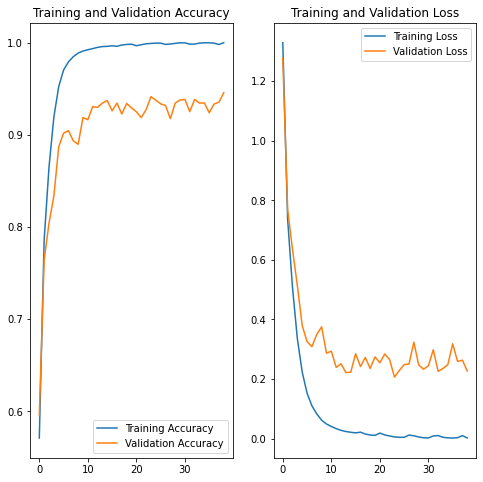

In [ ]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

40/40 [==============================] - 2s 45ms/step - loss: 0.2268 - accuracy: 0.9457
loss value: 0.227
accuracy value: 94.5674%


In [ ]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  off


In [ ]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: off


# (2) 2차원 Spectogram 데이터 셋 - (45553, 130, 126)

## - 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환함
## - 1차원의 1초 8000개의 샘플 데이터가 2차원 (130, 126) 샘플데이터로 변환됨
## - Spectogram data shape: (45553, 130, 126)

In [6]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf
from tensorflow.keras import layers
from tqdm.notebook import tqdm

In [8]:
data_path = '/content/drive/Shared drives/GOFOODA/DOS/wav/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [9]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [10]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  13566
Wave data shape :  (8000,)
label :  ['right']


In [11]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
label_value

{'down': 3,
 'go': 9,
 'left': 4,
 'no': 1,
 'off': 7,
 'on': 6,
 'right': 5,
 'silence': 11,
 'stop': 8,
 'unknown': 10,
 'up': 2,
 'yes': 0}

In [12]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
label_data, len(label_data)

(array([ 3,  3,  3, ..., 11, 11, 11]), 50620)

In [13]:
from sklearn.model_selection import train_test_split

sr = 8000  # sampling rate
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

[[ 3.4699945e-03  1.0581756e-02  6.3736876e-03 ... -1.9220835e-02
  -1.6774110e-02  4.3599706e-04]
 [-1.4082853e-09 -1.8641491e-09  6.6181105e-09 ... -1.2486353e-05
  -7.8811863e-05 -5.9669874e-05]
 [ 3.2606523e-04  6.2138011e-04  7.0704619e-04 ...  5.7315361e-04
   5.6308403e-04  5.0514319e-04]
 ...
 [-1.0128691e-06  1.1162293e-04  1.9110752e-04 ... -9.7161377e-05
  -1.4810085e-04 -1.9648179e-04]
 [ 4.6420293e-03  8.6271558e-03  2.3599945e-03 ...  5.5246195e-04
   7.0709200e-04 -5.5794241e-03]
 [-2.9283088e-05 -5.3535961e-04 -8.5817650e-04 ... -3.6054119e-04
   4.6738523e-06 -2.3606536e-04]]


In [14]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)


In [15]:
def wav2spec(wave, n_fft=258, expand_channel = True) :
    result_spec = np.zeros((len(wave), 130, 126))
    
    
    for idx, wav in tqdm(enumerate(wave)):
        result_spec[idx] = np.abs(librosa.stft(wav, n_fft=n_fft))
    
    if expand_channel:
        return result_spec[:,:,:,np.newaxis]
    
    return result_spec

In [16]:
train_spec = wav2spec(train_wav)
test_spec = wav2spec(test_wav)
print("Spectogram train data shape : ", train_spec.shape)
print("Spectogram test data shape : ", test_spec.shape)


Spectogram train data shape :  (45558, 130, 126, 1)
Spectogram test data shape :  (5062, 130, 126, 1)


In [17]:
train_wav_len = len(train_wav)
test_wav_len = len(test_wav)
train_wav_len, test_wav_len

(45558, 5062)

In [18]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [19]:
batch_size = 128
max_epochs = 100

train_ds = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_ds = train_ds.map(one_hot_label)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_ds = test_ds.map(one_hot_label)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(batch_size)

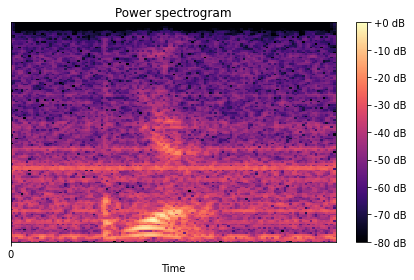

In [20]:
spectrogram = next(iter(train_ds))[0]

import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spectrogram[0,:,:,0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

# (2-1) Spectogram Classification Conv2D 모델 구현 - (45553, 130, 126)

## - Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
## - Conv1D layer를 이용: Conv, batch norm, dropout, dense layer 등을 이용해 모델 구성

In [21]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_specto = tf.keras.Model(input_tensor, output_tensor)

model_specto.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)       

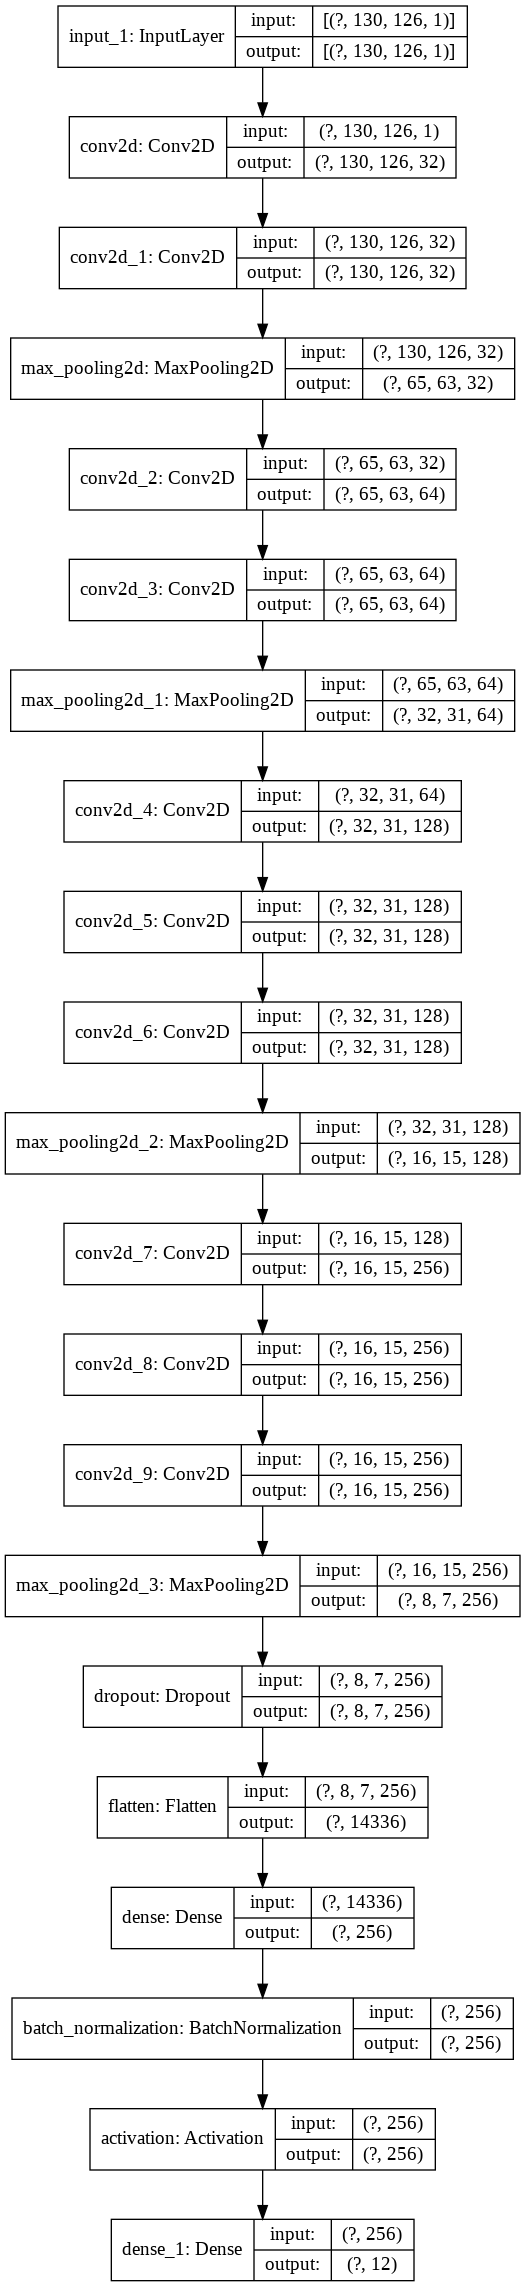

In [22]:
tf.keras.utils.plot_model(model_specto, '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto.png', show_shapes=True)

In [23]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_specto.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [24]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_ckp.h5'


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='auto', verbose=1)

In [25]:
#30분 내외 소요
history_specto = model_specto.fit(train_ds, epochs=max_epochs,
                    steps_per_epoch=train_wav_len // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_wav_len // batch_size,
                    callbacks=[cp_callback, es]
                    )

model_specto.save('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Model.h5')

Epoch 1/100
355/355 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.7209
Epoch 00001: val_accuracy improved from -inf to 0.86438, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_ckp.h5
355/355 [==============================] - 72s 203ms/step - loss: 0.8388 - accuracy: 0.7209 - val_loss: 0.5917 - val_accuracy: 0.8644
Epoch 2/100
355/355 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9181
Epoch 00002: val_accuracy improved from 0.86438 to 0.92889, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_ckp.h5
355/355 [==============================] - 68s 191ms/step - loss: 0.2513 - accuracy: 0.9181 - val_loss: 0.2155 - val_accuracy: 0.9289
Epoch 3/100
355/355 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9463
Epoch 00003: val_accuracy improved from 0.92889 to 0.94752, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_ckp.h5
355/355 [============

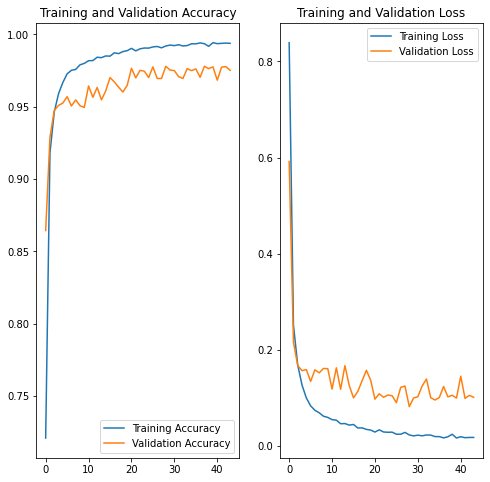

In [26]:
import matplotlib.pyplot as plt

acc = history_specto.history['accuracy']
val_acc = history_specto.history['val_accuracy']

loss=history_specto.history['loss']
val_loss=history_specto.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Evaluation 

model_specto.load_weights(checkpoint_dir)

In [28]:
# loss, accuracy
print("Best Validation Loss : {}".format(round(min(history_specto.history['val_loss']),4)))
print("Best Validation Accuracy : {}".format(round(max(history_specto.history['val_accuracy']),4)))

Best Validation Loss : 0.082
Best Validation Accuracy : 0.978


In [29]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_ckp.h5'
model_specto.load_weights(checkpoint_dir)

In [30]:
model_specto = tf.keras.models.load_model('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Model.h5')

In [31]:
# test

def spec2wav(spec, n_fft=258) :

    spec = spec.squeeze()
    wav = np.abs(librosa.istft(spec))
    
    return wav

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_specto(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  no


In [32]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))


y_pred: no


# (2-2) Spectogram Classification Conv2D Skip Connection 모델 구현 - (45553, 130, 126)

## - Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
## - 위의 Conv1D layer를 이용하지만 Skip Connection을 추가해서 모델을 구성함

In [33]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_specto_skip = tf.keras.Model(input_tensor, output_tensor)

model_specto_skip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 130, 126, 32) 2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_11[0][0]                  
_______________________________________________________________________________________

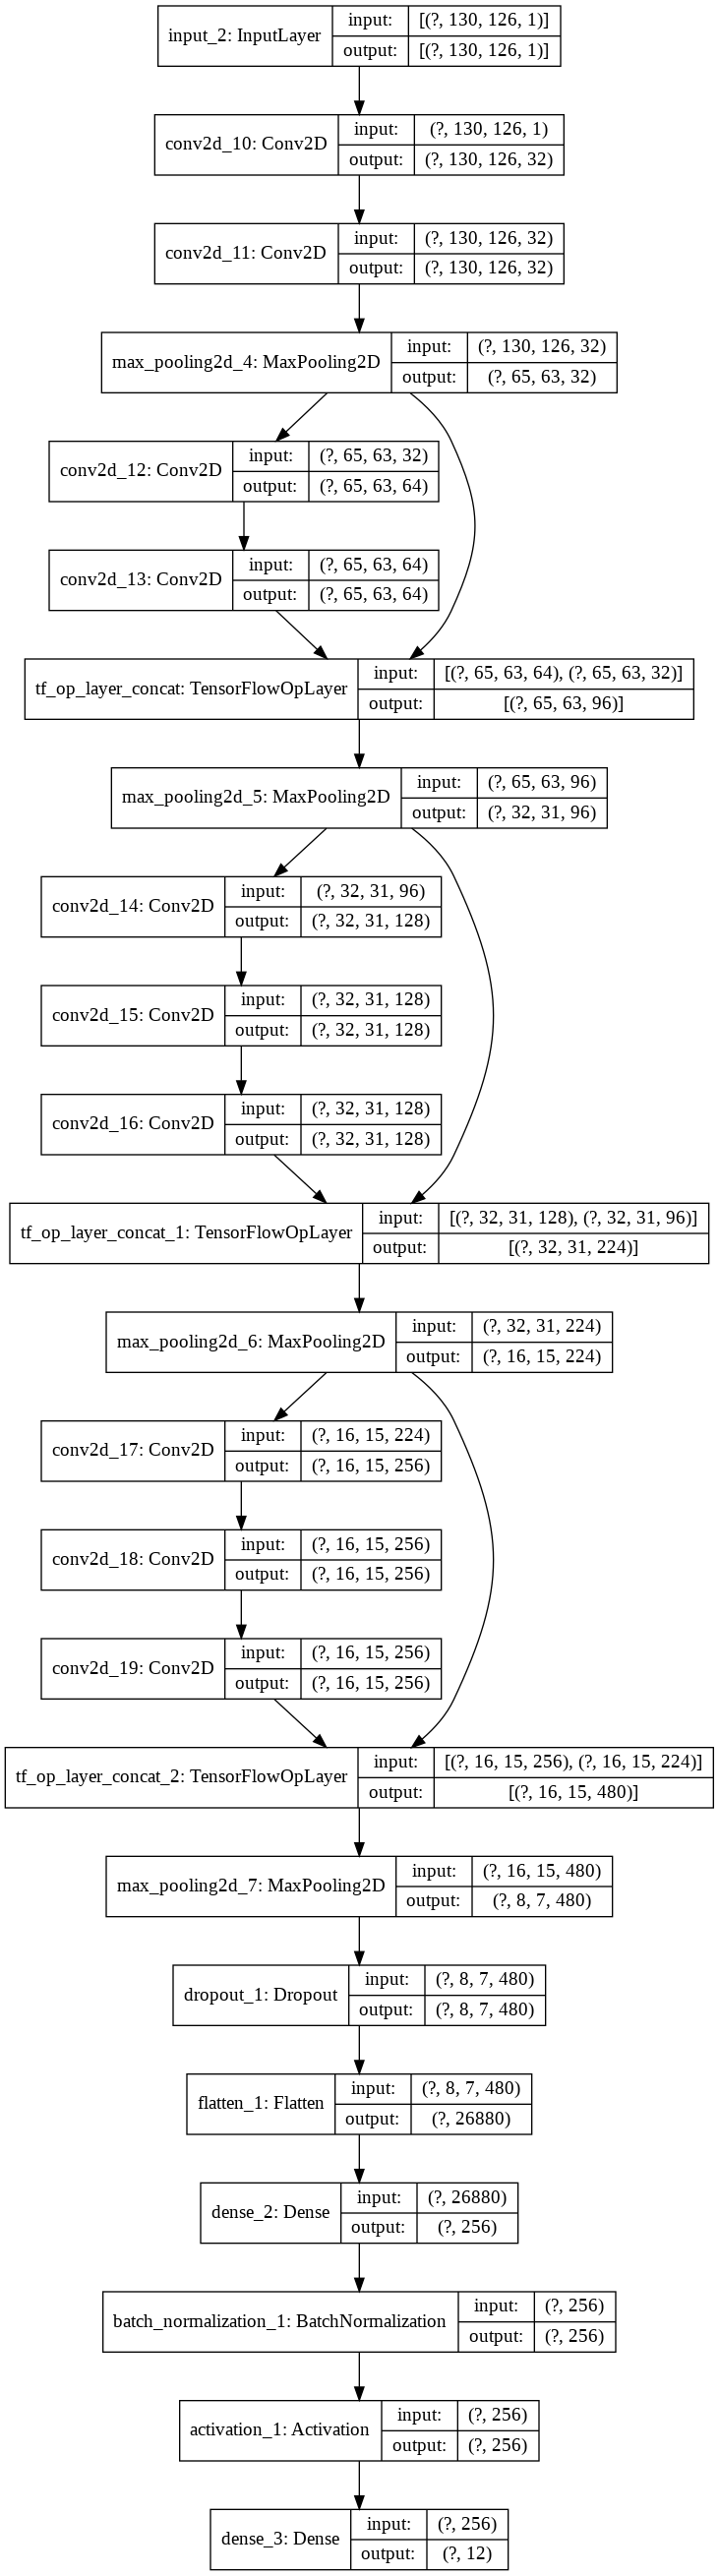

In [34]:
tf.keras.utils.plot_model(model_specto_skip, '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip.png', show_shapes=True)

In [35]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_specto_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [36]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_ckp.h5'


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='auto', verbose=1)

In [37]:
#30분 내외 소요
history_specto_skip = model_specto_skip.fit(train_ds, epochs=max_epochs,
                    steps_per_epoch=train_wav_len // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_wav_len // batch_size,
                    callbacks=[cp_callback, es]
                    )

model_specto_skip.save('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_Model.h5')

Epoch 1/100
355/355 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.7026
Epoch 00001: val_accuracy improved from -inf to 0.89784, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_ckp.h5
355/355 [==============================] - 72s 202ms/step - loss: 0.9107 - accuracy: 0.7026 - val_loss: 0.3514 - val_accuracy: 0.8978
Epoch 2/100
355/355 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9234
Epoch 00002: val_accuracy improved from 0.89784 to 0.92728, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_ckp.h5
355/355 [==============================] - 71s 199ms/step - loss: 0.2366 - accuracy: 0.9234 - val_loss: 0.2190 - val_accuracy: 0.9273
Epoch 3/100
355/355 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9531
Epoch 00003: val_accuracy improved from 0.92728 to 0.94712, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_ckp.h5
355/35

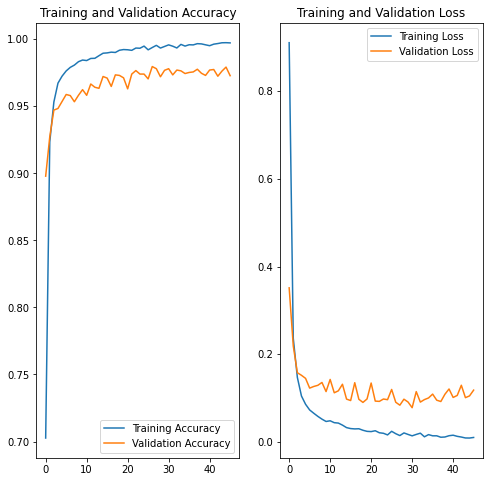

In [38]:
import matplotlib.pyplot as plt

acc = history_specto_skip.history['accuracy']
val_acc = history_specto_skip.history['val_accuracy']

loss=history_specto_skip.history['loss']
val_loss=history_specto_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
# Evaluation 

model_specto_skip.load_weights(checkpoint_dir)

In [40]:
# loss, accuracy
print("Best Validation Loss : {}".format(round(min(history_specto_skip.history['val_loss']),4)))
print("Best Validation Accuracy : {}".format(round(max(history_specto_skip.history['val_accuracy']),4)))

Best Validation Loss : 0.078
Best Validation Accuracy : 0.9796


In [41]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_ckp.h5'
model_specto_skip.load_weights(checkpoint_dir)

In [42]:
model_specto_skip = tf.keras.models.load_model('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto_Skip_Model.h5')

In [43]:
# test

def spec2wav(spec, n_fft=258) :

    spec = spec.squeeze()
    wav = np.abs(librosa.istft(spec))
    
    return wav

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_specto_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  no


In [44]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: no


# (3) 2차원 Spectogram 데이터 셋 - (45553, 130, 126)
## - 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환함
## - 1차원의 1초 8000개의 샘플 데이터가 2차원 (130, 126) 샘플데이터로 변환됨
## - Spectogram data shape: (45553, 130, 126)

In [45]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf
from tensorflow.keras import layers
from tqdm.notebook import tqdm

In [46]:
data_path = '/content/drive/Shared drives/GOFOODA/DOS/wav/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [47]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [48]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  5565
Wave data shape :  (8000,)
label :  ['left']


In [49]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
label_value

{'down': 3,
 'go': 9,
 'left': 4,
 'no': 1,
 'off': 7,
 'on': 6,
 'right': 5,
 'silence': 11,
 'stop': 8,
 'unknown': 10,
 'up': 2,
 'yes': 0}

In [50]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
label_data, len(label_data)

(array([ 3,  3,  3, ..., 11, 11, 11]), 50620)

In [51]:
from sklearn.model_selection import train_test_split

sr = 8000  # sampling rate
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

[[-3.4255386e-04 -4.2240537e-04 -3.6827126e-04 ... -6.3364347e-04
  -6.6851883e-04 -5.4386823e-04]
 [ 3.1768541e-05 -4.0157123e-05 -3.9802293e-05 ... -1.7740649e-06
   7.9236397e-06 -7.9191675e-05]
 [-3.6400794e-05 -9.0925787e-05 -6.4944390e-05 ...  1.5696902e-05
  -2.5603162e-05 -1.6173684e-05]
 ...
 [-5.6600088e-04 -9.5698889e-04 -8.8387751e-04 ...  9.6491154e-04
   8.5977750e-04  9.6166704e-04]
 [ 3.2898245e-04  5.3158973e-04  4.8193824e-04 ... -4.4158805e-04
  -3.5338418e-04 -4.7640401e-04]
 [ 2.1820790e-04  4.3142238e-04  5.7302579e-05 ... -1.1188558e-04
   4.5258766e-05 -3.9064034e-04]]


In [52]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)


In [53]:
def wav2spec(wave, n_fft=258, expand_channel = True) :
    result_spec = np.zeros((len(wave), 130, 126))
    
    
    for idx, wav in tqdm(enumerate(wave)):
        result_spec[idx] = np.abs(librosa.stft(wav, n_fft=n_fft))
    
    #if expand_channel:
        #return result_spec[:,:,:,np.newaxis]
    
    return result_spec

In [54]:
train_spec = wav2spec(train_wav)
test_spec = wav2spec(test_wav)
print("Spectogram train data shape : ", train_spec.shape)
print("Spectogram test data shape : ", test_spec.shape)


Spectogram train data shape :  (45558, 130, 126)
Spectogram test data shape :  (5062, 130, 126)


In [55]:
train_wav_len = len(train_wav)
test_wav_len = len(test_wav)
train_wav_len, test_wav_len

(45558, 5062)

In [56]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [57]:
batch_size = 128
max_epochs = 100

train_ds = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_ds = train_ds.map(one_hot_label)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_ds = test_ds.map(one_hot_label)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(batch_size)

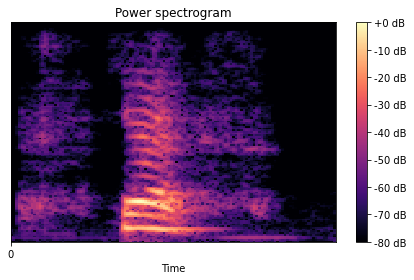

In [58]:
spectrogram = next(iter(train_ds))[0]

import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spectrogram[0,:,:], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

# (3-1) Spectogram Classification Conv1D 모델 구현 - (45553, 130, 126)

## - Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
## - Conv1D layer를 이용: Conv, batch norm, dropout, dense layer 등을 이용해 모델 구성

In [59]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_specto = tf.keras.Model(input_tensor, output_tensor)

model_specto.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)           

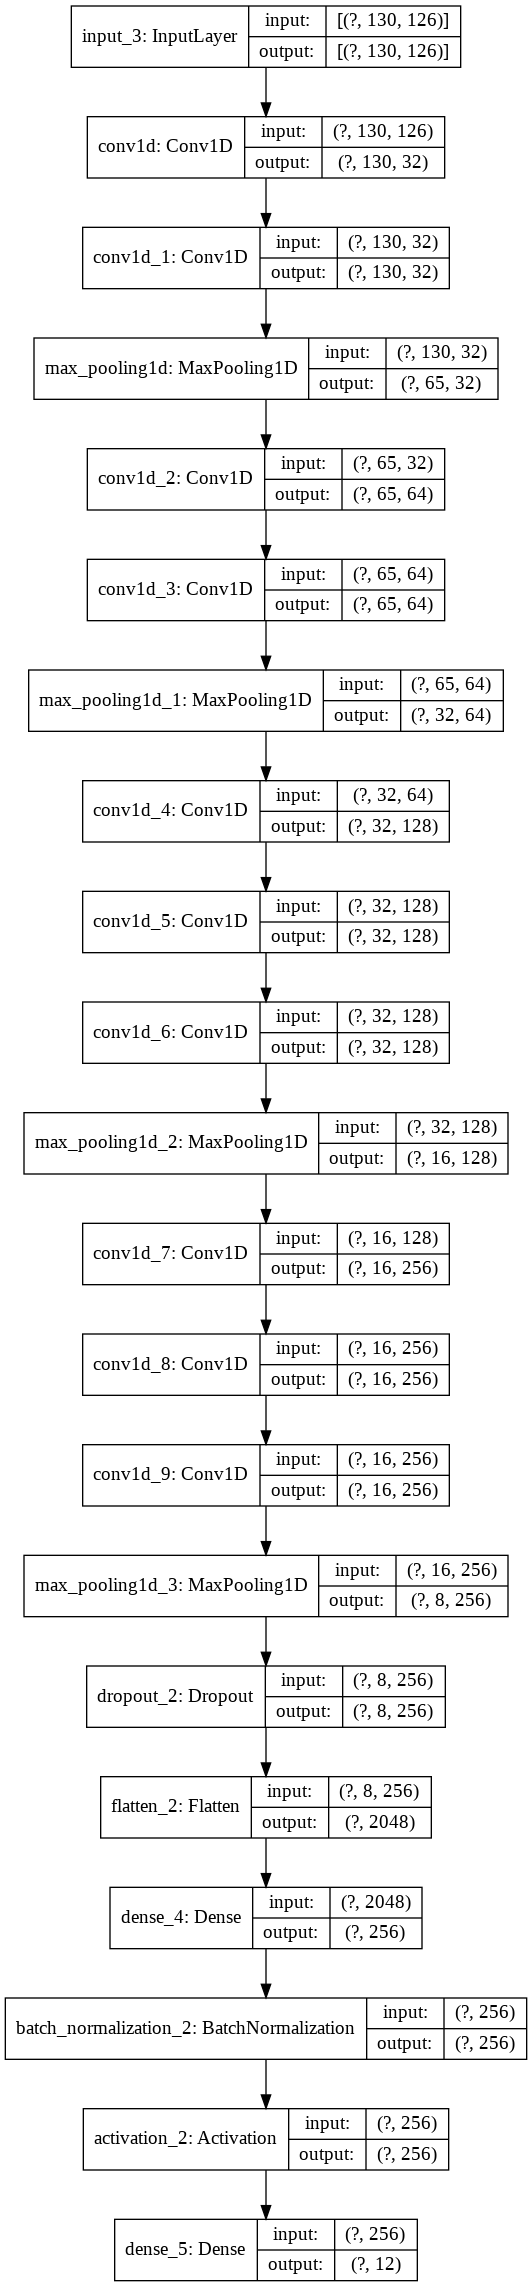

In [60]:
tf.keras.utils.plot_model(model_specto, '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1.png', show_shapes=True)

In [61]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_specto.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [62]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_ckp.h5'


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='auto', verbose=1)

In [63]:
#30분 내외 소요
history_specto = model_specto.fit(train_ds, epochs=max_epochs,
                    steps_per_epoch=train_wav_len // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_wav_len // batch_size,
                    callbacks=[cp_callback, es]
                    )

model_specto.save('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Model.h5')

Epoch 1/100
353/355 [============================>.] - ETA: 0s - loss: 1.5945 - accuracy: 0.4567
Epoch 00001: val_accuracy improved from -inf to 0.61238, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_ckp.h5
355/355 [==============================] - 12s 33ms/step - loss: 1.5920 - accuracy: 0.4575 - val_loss: 1.6816 - val_accuracy: 0.6124
Epoch 2/100
354/355 [============================>.] - ETA: 0s - loss: 0.9113 - accuracy: 0.6899
Epoch 00002: val_accuracy improved from 0.61238 to 0.76142, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_ckp.h5
355/355 [==============================] - 11s 30ms/step - loss: 0.9109 - accuracy: 0.6901 - val_loss: 0.7171 - val_accuracy: 0.7614
Epoch 3/100
354/355 [============================>.] - ETA: 0s - loss: 0.5844 - accuracy: 0.8057
Epoch 00003: val_accuracy improved from 0.76142 to 0.82011, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_ckp.h5
355/355 [===========

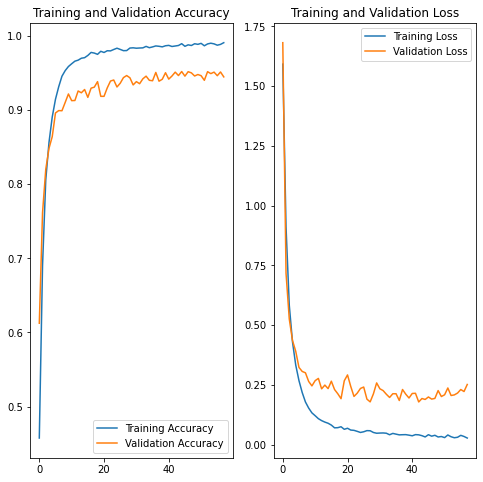

In [64]:
import matplotlib.pyplot as plt

acc = history_specto.history['accuracy']
val_acc = history_specto.history['val_accuracy']

loss=history_specto.history['loss']
val_loss=history_specto.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
# Evaluation 

model_specto.load_weights(checkpoint_dir)

In [66]:
# loss, accuracy
print("Best Validation Loss : {}".format(round(min(history_specto.history['val_loss']),4)))
print("Best Validation Accuracy : {}".format(round(max(history_specto.history['val_accuracy']),4)))

Best Validation Loss : 0.1782
Best Validation Accuracy : 0.9519


In [67]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_ckp.h5'
model_specto.load_weights(checkpoint_dir)

In [68]:
model_specto = tf.keras.models.load_model('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Model.h5')

In [69]:
# test

def spec2wav(spec, n_fft=258) :

    spec = spec.squeeze()
    wav = np.abs(librosa.istft(spec))
    
    return wav

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_specto(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  unknown


In [70]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))


y_pred: unknown


# (3-2) Spectogram Classification Conv1D Skip Connection 모델 구현 - (45553, 130, 126)

## - Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
## - 위의 Conv1D layer를 이용하지만 Skip Connection을 추가해서 모델을 구성함

In [71]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_specto_skip = tf.keras.Model(input_tensor, output_tensor)

model_specto_skip.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
_______________________________________________________________________________________

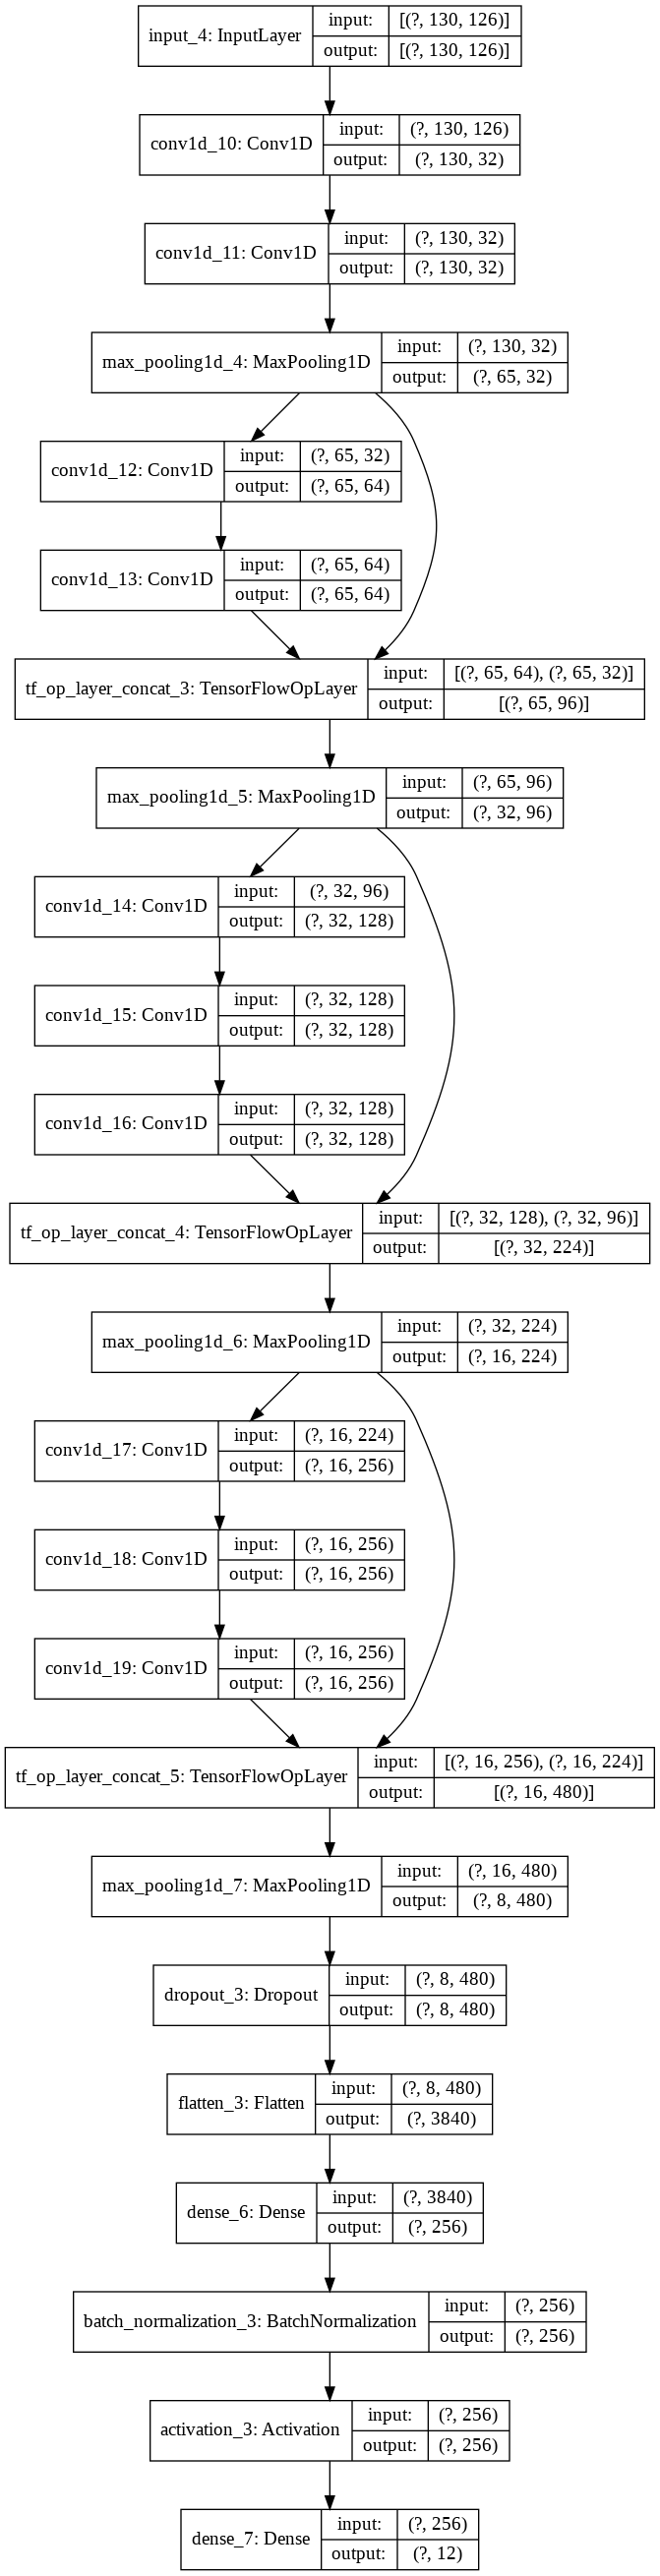

In [72]:
tf.keras.utils.plot_model(model_specto_skip, '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip.png', show_shapes=True)

In [73]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_specto_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [74]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_ckp.h5'


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='auto', verbose=1)

In [75]:
#30분 내외 소요
history_specto_skip = model_specto_skip.fit(train_ds, epochs=max_epochs,
                    steps_per_epoch=train_wav_len // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_wav_len // batch_size,
                    callbacks=[cp_callback, es]
                    )

model_specto_skip.save('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_Model.h5')

Epoch 1/100
354/355 [============================>.] - ETA: 0s - loss: 1.7233 - accuracy: 0.4250
Epoch 00001: val_accuracy improved from -inf to 0.58694, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_ckp.h5
355/355 [==============================] - 12s 34ms/step - loss: 1.7220 - accuracy: 0.4255 - val_loss: 1.2398 - val_accuracy: 0.5869
Epoch 2/100
355/355 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.6931
Epoch 00002: val_accuracy improved from 0.58694 to 0.75801, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_ckp.h5
355/355 [==============================] - 10s 30ms/step - loss: 0.9188 - accuracy: 0.6931 - val_loss: 0.7223 - val_accuracy: 0.7580
Epoch 3/100
355/355 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.8054
Epoch 00003: val_accuracy improved from 0.75801 to 0.80689, saving model to /content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_ckp.h5
355/3

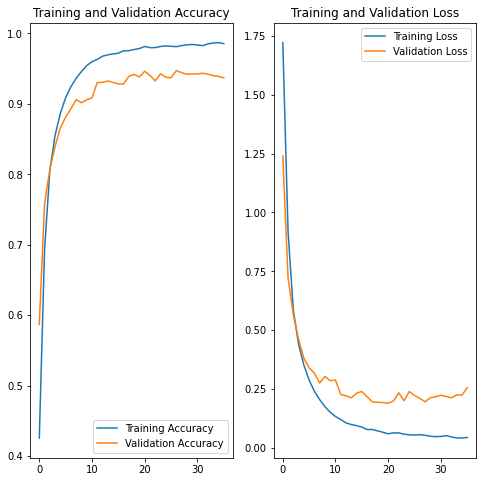

In [76]:
import matplotlib.pyplot as plt

acc = history_specto_skip.history['accuracy']
val_acc = history_specto_skip.history['val_accuracy']

loss=history_specto_skip.history['loss']
val_loss=history_specto_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
# Evaluation 

model_specto_skip.load_weights(checkpoint_dir)

In [78]:
# loss, accuracy
print("Best Validation Loss : {}".format(round(min(history_specto_skip.history['val_loss']),4)))
print("Best Validation Accuracy : {}".format(round(max(history_specto_skip.history['val_accuracy']),4)))

Best Validation Loss : 0.1882
Best Validation Accuracy : 0.9473


In [79]:
checkpoint_dir = '/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_ckp.h5'
model_specto_skip.load_weights(checkpoint_dir)

In [80]:
model_specto_skip = tf.keras.models.load_model('/content/drive/Shared drives/GOFOODA/DOS/YesicaKim/Specto1_Skip_Model.h5')

In [81]:
# test

def spec2wav(spec, n_fft=258) :

    spec = spec.squeeze()
    wav = np.abs(librosa.istft(spec))
    
    return wav

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_specto_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  silence


In [82]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: silence


# 결론

## 학습 결과 

- ***Spectogram 2차원 데이터로 Conv2D Skip Connection Model로 돌렸을 때, Valication Accuracy는 97.96%로 가장 좋았고, 와 Valicatino Loss는 0.078로 가장 낮았다.***
- ***Wave 1차원 데이터를 Con1D 모델로 돌렸을 때는 Base Model보다 Skip Connection Model의 성능이 0.9285% 높게 나왔다.*** 
- ***Spectorgram 2차원 데이터를 Con2D 모델로 돌렸을 때에도 Base Model보다 Skip Connection Model의 성능이 0.16% 높게 나왔다.*** 
- ***하지만 Spectorgram 2차원 데이터를 Con1D 모델로 돌렸을 때에는 Base Model보다 Skip Connection Model의 성능이 0.46% 낮게 나왔다.*** 


### (1) 1차원 Wave 데이터 셋 - (50620, 8000)

- npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어 있음
- 1초 길이의 오디오 음성 데이터 50620개, 각각 8000개의 샘플 데이터를 가짐
- ***Wave data shape: (50620, 8000)***

### (1-1) Wave Classification 첫번째 모델 구현 - (50620, 8000)

- Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
- Conv1D layer를 이용: Conv, batch norm, dropout, dense layer 등을 이용해 모델 구성
- ***Wav base model (Conv1D) : (8000, 1) 학습결과***
  - loss value: ***0.235***
  - accuracy value: ***93.6389%***

![title](Wave1-1.png)

### (1-2) Wave Classification 두번째 모델 구현 - (50620, 8000)

- Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
- 위의 Conv1D layer를 이용하지만 Skip Connection을 추가해서 모델을 구성함
- ***Wav skip connection model (Conv1D) : (8000, 1) 학습결과***
  - loss value: ***0.227***
  - accuracy value: ***94.5674%***
  
![title](Wave1-2.png)

### (2) 2차원 Spectogram 데이터 셋 - (45553, 130, 126, 1)

- 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환함
- 1차원의 1초 8000개의 샘플 데이터가 2차원 (130, 126) 샘플데이터로 변환됨
- ***Spectogram data shape: (45553, 130, 126, 1)***

### (2-1) Spectogram Classification Conv2D 모델 구현 - (45553, 130, 126, 1)

- Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
- Conv1D layer를 이용: Conv, batch norm, dropout, dense layer 등을 이용해 모델 구성
- ***Spectogram base model (Conv2D) : (130, 126, 1) 학습결과***
  - Best Validation Loss : ***0.082***
  - Best Validation Accuracy : ***97.8%***

![title](Specto2-1.png)

### (2-2) Spectogram Classification Conv2D Skip Connection 모델 구현 - (45553, 130, 126, 1)

- Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
- 위의 Conv1D layer를 이용하지만 Skip Connection을 추가해서 모델을 구성함
- ***Spectogram skip connection model (Conv2D) : (130, 126, 1) 학습결과***
  - Best Validation Loss : ***0.078***
  - Best Validation Accuracy : ***97.96%***
  
![title](Specto2-2.png)

### (3) 2차원 Spectogram 데이터 셋 - (45553, 130, 126)
- 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환함
- 1차원의 1초 8000개의 샘플 데이터가 2차원 (130, 126) 샘플데이터로 변환됨
- ***Spectogram data shape: (45553, 130, 126)***

### (3-1) Spectogram Classification Conv1D 모델 구현 - (45553, 130, 126)

- Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
- Conv1D layer를 이용: Conv, batch norm, dropout, dense layer 등을 이용해 모델 구성
- ***Spectogram base model (Conv1D) : (130, 126) 학습결과***
  - Best Validation Loss : ***0.1782***
  - Best Validation Accuracy : ***95.19%***

![title](Specto3-1.png)

### (3-2) Spectogram Classification Conv1D Skip Connection 모델 구현 - (45553, 130, 126)

- Spectogram Audio 데이터는 2차원 데이터이기 때문에 데이터 형식에 맞도록 모델 구성함
- 위의 Conv1D layer를 이용하지만 Skip Connection을 추가해서 모델을 구성함
- ***Spectogram skip connection model (Conv1D) : (130, 126) 학습결과***
  - Best Validation Loss : ***0.1882***
  - Best Validation Accuracy : ***94.73%***
  
![title](Specto3-1.png)